Results will be saved to: D:\\german\\Kernel-ridge-regression\Adult\\results
Dataset loaded successfully, 32561 rows, 15 columns

===== Basic Data Information =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  income          3

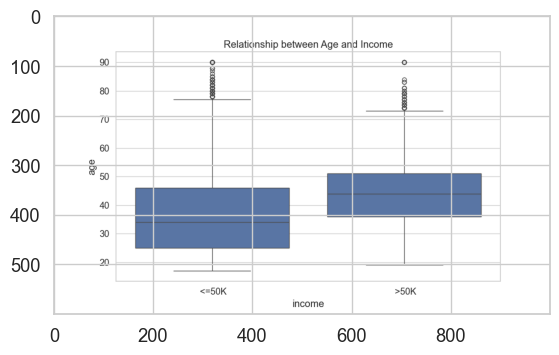

In [ ]:
# %pip install pandas
# %pip install seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import joblib
import os

path = "D:\\german\\Kernel-ridge-regression\\Adult\\results\\figures\\"

# 设置中文显示 (Set up Chinese display)
plt.rcParams["font.family"] = ["SimHei", "WenQuanYi Micro Hei", "Heiti TC"]
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

def main():
    # 1. 配置路径 (Configure paths)
    # 数据集路径 - 可根据实际情况修改 (Dataset path - modify as needed)
    # data_path = os.path.join("Adult", "adult", "adult.data")
    data_path = r"D:\\german\\Kernel-ridge-regression\\Adult\\adult\\adult.data"
    # 结果保存根路径 (Root path for saving results)
    results_root = r"D:\\german\\Kernel-ridge-regression\Adult\\results"
    # 创建结果目录（包括子目录）(Create result directories including subdirectories)
    model_dir = os.path.join(results_root, "models")
    figures_dir = os.path.join(results_root, "figures")
    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(figures_dir, exist_ok=True)
    print(f"Results will be saved to: {results_root}")

    # 2. 加载数据集 (Load dataset)
    column_names = [
        "age", "workclass", "fnlwgt", "education", "education-num",
        "marital-status", "occupation", "relationship", "race", "sex",
        "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"
    ]
    
    try:
        data = pd.read_csv(data_path, header=None, names=column_names)
        print(f"Dataset loaded successfully, {data.shape[0]} rows, {data.shape[1]} columns")
    except FileNotFoundError:
        print(f"Error: Dataset file not found, please check the path: {data_path}")
        return
    
    # 3. 数据探索与预处理 (Data exploration and preprocessing)
    print("\n===== Basic Data Information =====")
    print(data.info())
    
    print("\n===== Data Statistical Summary =====")
    print(data.describe())
    
    # 检查缺失值（数据集用'?'表示缺失值）(Check for missing values - dataset uses '?' for missing values)
    print("\n===== Missing Value Statistics =====")
    for col in data.columns:
        missing_count = (data[col] == '?').sum()
        if missing_count > 0:
            print(f"{col}: {missing_count} missing values ({missing_count/len(data):.2%})")
    
    # 处理缺失值：用众数填充 (Handle missing values: fill with mode)
    for col in data.columns:
        if (data[col] == '?').sum() > 0:
            # 找到众数（排除'?'）(Find mode value - excluding '?')
            mode_val = data[data[col] != '?'][col].mode()[0]
            data[col] = data[col].replace('?', mode_val)
            print(f"Filled missing values in {col} with mode '{mode_val}'")
    
    # 分离特征和目标变量 (Separate features and target variable)
    X = data.drop("income", axis=1)
    y = data["income"]
    
    # 目标变量编码（用于ROC曲线）(Encode target variable for ROC curve)
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    # 确定分类特征和数值特征列 (Identify categorical and numerical features)
    categorical_features = ["workclass", "education", "marital-status", 
                           "occupation", "relationship", "race", "sex", "native-country"]
    numerical_features = ["age", "fnlwgt", "education-num", "capital-gain", 
                         "capital-loss", "hours-per-week"]
    
    # 收入分布可视化 (Income distribution visualization)
    plt.figure(figsize=(8, 6))
    sns.countplot(x="income", data=data)
    plt.title("Income Distribution")  # 收入分布
    income_dist_path = os.path.join(figures_dir, "income_distribution.png")
    plt.savefig(income_dist_path)
    plt.close()
    print(f"Generated income distribution visualization: {income_dist_path}")
    
    # 年龄与收入关系可视化 (Visualization of age vs income relationship)
    plt.figure(figsize=(10, 6))
    sns.boxplot(x="income", y="age", data=data)
    plt.title("Relationship between Age and Income")  # 年龄与收入的关系
    age_income_path = os.path.join(figures_dir, "age_vs_income.png")
    plt.savefig(age_income_path)
    plt.close()
    print(f"Generated age vs income relationship chart: {age_income_path}")
    
    # 创建预处理管道 (Create preprocessing pipeline)
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), numerical_features),
            ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features)
        ]
    )
    
    # 4. 划分训练集和测试集 (Split into training and testing sets)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    _, _, y_train_encoded, y_test_encoded = train_test_split(
        X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )
    
    print(f"\nTraining set samples: {X_train.shape[0]}, Test set samples: {X_test.shape[0]}")
    
    # 5. 构建并训练模型 (Build and train the model)
    print("\n===== Starting Random Forest Model Training =====")
    model = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", RandomForestClassifier(
            n_estimators=100, 
            max_depth=10,  # 限制树深度防止过拟合 (Limit tree depth to prevent overfitting)
            min_samples_split=10,
            random_state=42,
            n_jobs=-1  # 使用所有可用CPU (Use all available CPUs)
        ))
    ])
    
    # 交叉验证 (Cross-validation)
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"Cross-validation accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    
    # 训练模型 (Train the model)
    model.fit(X_train, y_train)
    
    # 6. 模型评估 (Model evaluation)
    print("\n===== Model Evaluation Results =====")
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # 用于ROC曲线 (For ROC curve)
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Test set accuracy: {accuracy:.4f}")
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # 混淆矩阵 (Confusion matrix)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=model.classes_, 
                yticklabels=model.classes_)
    plt.xlabel("Predicted Label")  # 预测标签
    plt.ylabel("True Label")  # 真实标签
    plt.title("Confusion Matrix")  # 混淆矩阵
    cm_path = os.path.join(figures_dir, "confusion_matrix.png")
    plt.savefig(cm_path)
    plt.close()
    print(f"Generated confusion matrix chart: {cm_path}")
    
    # ROC曲线 (ROC curve)
    fpr, tpr, _ = roc_curve(y_test_encoded, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (Area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')  # 假正例率
    plt.ylabel('True Positive Rate')  # 真正例率
    plt.title('ROC Curve')  # ROC曲线
    plt.legend(loc="lower right")
    roc_path = os.path.join(figures_dir, "roc_curve.png")
    plt.savefig(roc_path)
    plt.close()
    print(f"Generated ROC curve chart: {roc_path}")
    
    # 7. 特征重要性分析 (Feature importance analysis)
    # 获取独热编码后的特征名称 (Get feature names after one-hot encoding)
    ohe = model.named_steps['preprocessor'].named_transformers_['cat']
    cat_feature_names = list(ohe.get_feature_names_out(categorical_features))
    all_feature_names = numerical_features + cat_feature_names
    
    # 获取特征重要性 (Get feature importances)
    importances = model.named_steps['classifier'].feature_importances_
    indices = np.argsort(importances)[::-1]
    
    # 打印前10个重要特征 (Print top 10 important features)
    print("\n===== Important Features (Top 10) =====")
    for f in range(min(10, len(all_feature_names))):
        print(f"{all_feature_names[indices[f]]}: {importances[indices[f]]:.4f}")
    
    # 可视化特征重要性 (Visualize feature importance)
    plt.figure(figsize=(12, 8))
    plt.barh(range(min(15, len(all_feature_names))), 
             importances[indices[:15]], 
             align='center')
    plt.yticks(range(min(15, len(all_feature_names))), 
               [all_feature_names[i] for i in indices[:15]])
    plt.xlabel('Feature Importance')  # 特征重要性
    plt.title('Random Forest Feature Importance (Top 15)')  # 随机森林特征重要性（前15）
    plt.gca().invert_yaxis()  # 最重要的在上面 (Most important at the top)
    plt.tight_layout()
    fi_path = os.path.join(figures_dir, "feature_importance.png")
    plt.savefig(fi_path)
    plt.close()
    print(f"Generated feature importance chart: {fi_path}")
    
    # 8. 保存模型 (Save the model)
    model_path = os.path.join(model_dir, "adult_income_model.pkl")
    joblib.dump(model, model_path)
    print(f"\nModel saved to: {model_path}")
    
    # 9. 示例预测 (Example predictions)
    print("\n===== Example Predictions =====")
    # 随机选择5个测试样本 (Randomly select 5 test samples)
    sample_indices = np.random.choice(X_test.index, 5, replace=False)
    sample_data = X_test.loc[sample_indices]
    sample_actual = y_test.loc[sample_indices]
    sample_pred = model.predict(sample_data)
    
    # 显示预测结果 (Display prediction results)
    result_df = pd.DataFrame({
        'Actual Income': sample_actual,  # 实际收入
        'Predicted Income': sample_pred  # 预测收入
    })
    print(result_df)
    img = mpimg.imread(path + "age_vs_income.png")  # 读取图片
    plt.imshow(img)  # 显示图片数据

if __name__ == "__main__":
    main()
    

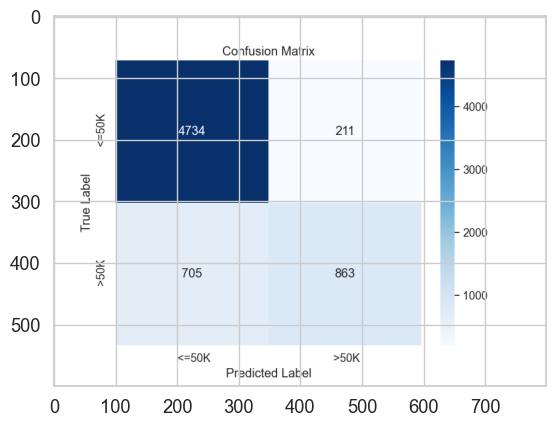

In [32]:
img = mpimg.imread(path + "confusion_matrix.png")  # 读取图片
plt.imshow(img)  # 显示图片数据

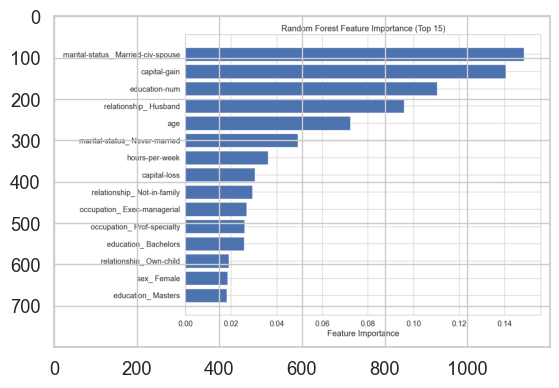

In [33]:
img = mpimg.imread(path + "feature_importance.png")  # 读取图片
plt.imshow(img)  # 显示图片数据

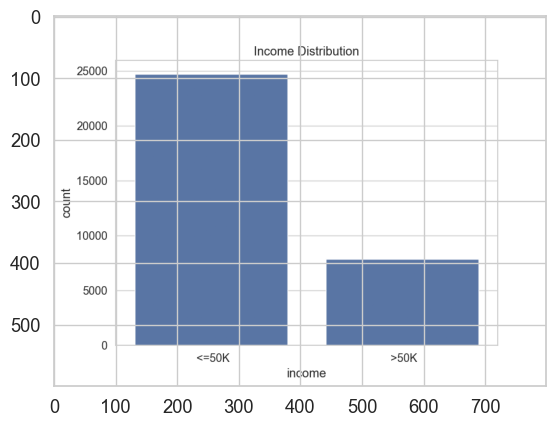

In [34]:
img = mpimg.imread(path + "income_distribution.png")  # 读取图片
plt.imshow(img)  # 显示图片数据

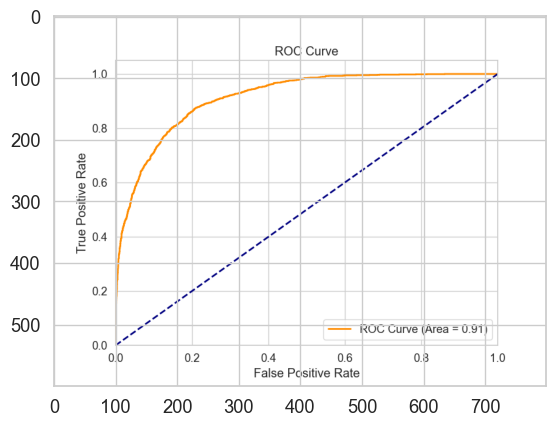

In [35]:
img = mpimg.imread(path + "roc_curve.png")  # 读取图片
plt.imshow(img)  # 显示图片数据